# Introduction


**What?** Can an MLP learn an asymptotic behaviour?



# Import modules

In [1]:
import copy, os, copy, math
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from scipy.interpolate import Rbf, UnivariateSpline, splrep, splev, InterpolatedUnivariateSpline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from keras.layers import BatchNormalization, Dropout
# Some general plotting settings
rcParams['figure.figsize'] = 17, 5
rcParams['font.size'] = 15
# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Can we use an MLP to learn an asymptotic trend?


- To answer this question we'll **artificially** create a dataset showing an asymptotic trend.
- This is representative of a physical system where one of its control variable, if varied, the response shows an **asymptotic trend**.



# Creation of a synthetic function

In [44]:
def asymptoticFunction(b):
    x = np.arange(0, 20, 0.1)
    y = (b/np.log(x)**0.001)*(1/x**1.75)
    return x, y

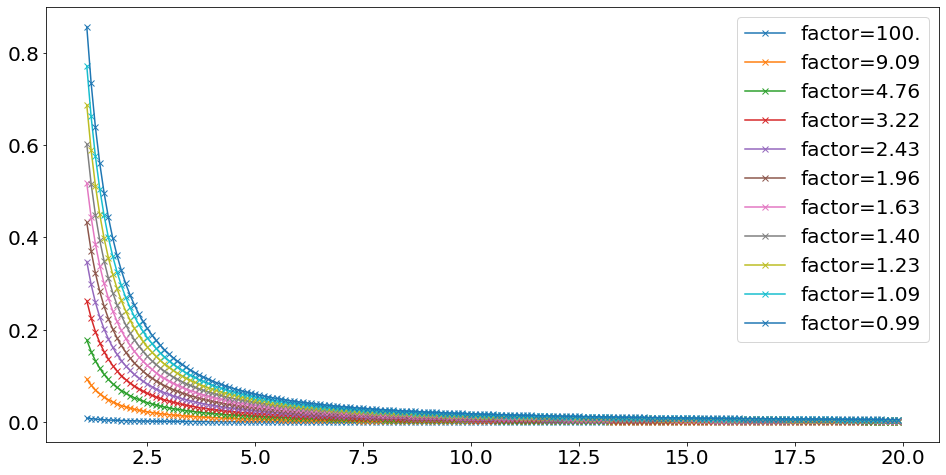

In [45]:
data = []
for b in np.arange(0.01, 1.1, 0.1):
    x, y = asymptoticFunction(b)
    plt.plot(x, y, "-x", label="factor=" + str(1/b)[:4])
    data.append([x, y, 1/b])
plt.legend()


- If an asymptotic trend is present then using a log scale helps visualise the trend.
- It has also another property: the the curves becomes straight line.
- Further, for machine learning, learning a couple of straight lines would be much easier.



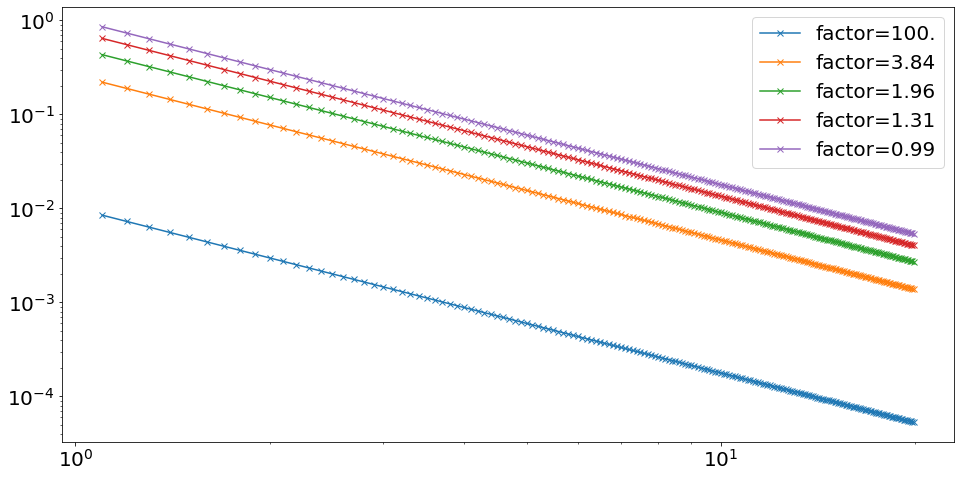

In [48]:
for b in np.arange(0.01, 1.1, 0.25):
    x, y = asymptoticFunction(b)
    plt.plot(x, y, "-x", label="factor=" + str(1/b)[:4])

plt.xscale('log')
plt.yscale('log')
plt.legend()


- The graph above can be obtained also if we apply the `np.log10` directly on the data.
- Essentially we are transformng the input.
- We have used `np.log10` and not `np.log` just because `plt.xscale('log')` used a base 10 log.



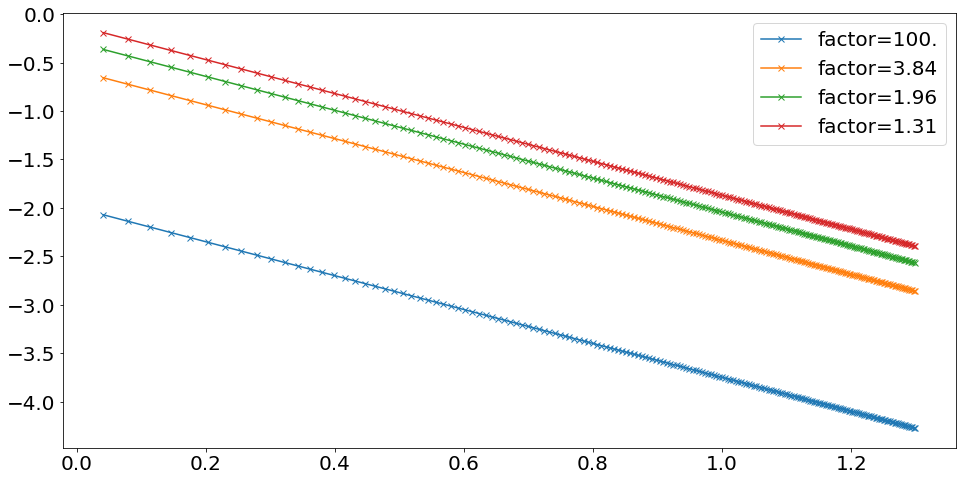

In [49]:
for b in np.arange(0.01, 1, 0.25):
    x, y = asymptoticFunction(b)
    plt.plot(np.log10(x), np.log10(y), "-x", label="factor="+str(1/b)[:4])

plt.legend()

# Create a pandas dataset

In [50]:
x1, x2, y, = [],[],[]
for i in range(len(data)):
    x1.append(data[i][0])
    y.append(data[i][1])
    x2.append([data[i][2] for _ in range(len(data[i][1]))])    

In [51]:
x1 = np.array(x1).flatten()
y = np.array(y).flatten()
x2 = np.array(x2).flatten()
print(len(x1), len(x2), len(y))

2200 2200 2200


In [8]:
df = pd.DataFrame()
df["x1"] = x1
df["y"]  = y
df["x2"] = x2

In [9]:
df

,x1,y,x2
0,0.0,NaN,100.00000
1,0.1,NaN,100.00000
2,0.2,NaN,100.00000
3,0.3,NaN,100.00000
4,0.4,NaN,100.00000
...,...,...,...
3745,24.5,0.005220,0.70922
3746,24.6,0.005183,0.70922
3747,24.7,0.005146,0.70922
3748,24.8,0.005110,0.70922


In [10]:
df = df.replace(np.inf, np.NaN)
df = df.dropna(how = 'any', axis = 0) 

In [11]:
df

,x1,y,x2
11,1.1,0.008484,100.00000
12,1.2,0.007281,100.00000
13,1.3,0.006327,100.00000
14,1.4,0.005556,100.00000
15,1.5,0.004923,100.00000
...,...,...,...
3745,24.5,0.005220,0.70922
3746,24.6,0.005183,0.70922
3747,24.7,0.005146,0.70922
3748,24.8,0.005110,0.70922


# Splitting the dataset

In [12]:
X = df.drop(columns = ["y"])
# Manualy scaling the output. A more elegant solution would be to normalise btw 0 and 1
y = df["y"]*1000

In [13]:
y

11      8.483668
12      7.280681
13      6.326744
14      5.555831
15      4.923028
          ...   
3745    5.220036
3746    5.182952
3747    5.146280
3748    5.110014
3749    5.074148
Name: y, Length: 3585, dtype: float64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .2,
                                                    shuffle = True, 
                                                    random_state = 7)

In [15]:
early_stopping = callbacks.EarlyStopping(
    # Minimium amount of change to count as an improvement
    min_delta = 0.1, 
    # How many epochs to wait before stopping
    patience = 50, 
    restore_best_weights=True,
)

# Modelling

In [16]:
model = tf.keras.models.Sequential()
No_neurons_per_layer = 230
model.add(tf.keras.layers.Dense(No_neurons_per_layer, activation = 'relu', input_dim = 2))
model.add(tf.keras.layers.Dense(No_neurons_per_layer, activation = 'relu'))
model.add(tf.keras.layers.Dense(No_neurons_per_layer, activation = 'relu'))
model.add(tf.keras.layers.Dense(No_neurons_per_layer, activation = 'relu'))
model.add(tf.keras.layers.Dense(No_neurons_per_layer, activation = 'relu'))
model.add(tf.keras.layers.Dense(No_neurons_per_layer, activation = 'relu'))
model.add(tf.keras.layers.Dense(No_neurons_per_layer, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'linear'))


model.compile(optimizer = 'adam', loss = "MAE")
history = model.fit(X_train.values, y_train.values, 
                     epochs = 300, 
                     validation_data=(X_test, y_test), 
                     callbacks = [early_stopping])

prediction = model.predict(X_test)


Epoch 1/300
90/90 [==============================] - 1s 5ms/step - loss: 32.7837 - val_loss: 28.3850
Epoch 2/300
90/90 [==============================] - 0s 3ms/step - loss: 14.1763 - val_loss: 5.7240
Epoch 3/300
90/90 [==============================] - 0s 3ms/step - loss: 3.9796 - val_loss: 2.7355
Epoch 4/300
90/90 [==============================] - 0s 3ms/step - loss: 4.4396 - val_loss: 4.0937
Epoch 5/300
90/90 [==============================] - 0s 3ms/step - loss: 2.7628 - val_loss: 4.6974
Epoch 6/300
90/90 [==============================] - 0s 3ms/step - loss: 3.5962 - val_loss: 1.9857
Epoch 7/300
90/90 [==============================] - 0s 3ms/step - loss: 2.1683 - val_loss: 1.3428
Epoch 8/300
90/90 [==============================] - 0s 3ms/step - loss: 2.2954 - val_loss: 2.3900
Epoch 9/300
90/90 [==============================] - 0s 3ms/step - loss: 2.1884 - val_loss: 0.8672
Epoch 10/300
90/90 [==============================] - 0s 3ms/step - loss: 1.9939 - val_loss: 1.7650
Epoch 

# Model diagnostic

range(0, 108)


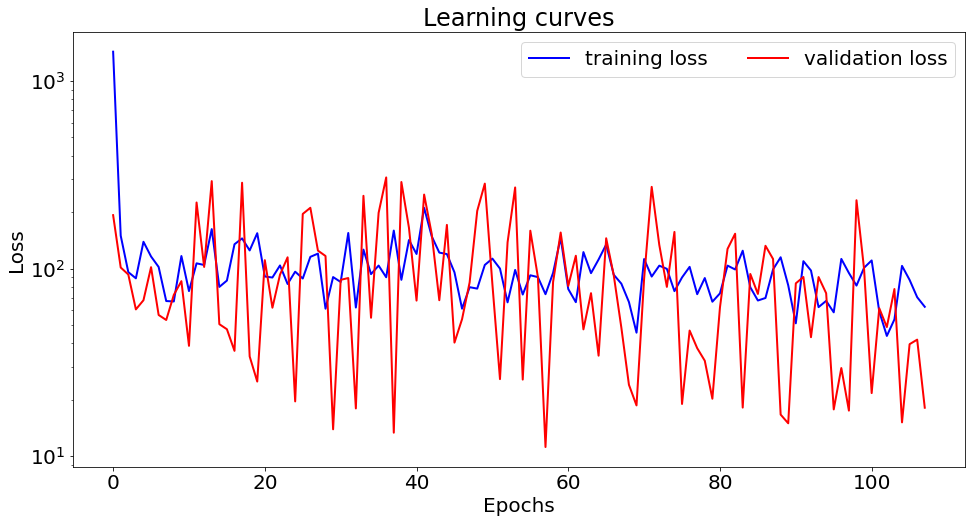

In [52]:
fig = plt.figure() 
plt.title("Learning curves")
ax = fig.add_subplot(111) 

dummy = range(len(history.history["loss"]))
print(dummy)

plt.plot(dummy, history.history["loss"], "-b", lw = 2, ms = 8, label = "training loss")
plt.plot(dummy, history.history["val_loss"], "-r", lw = 2, ms = 8, label = "validation loss")


ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")

plt.yscale('log')
plt.legend(loc = 'upper right', ncol = 2);

In [53]:
preds = model.predict(X_test)

r2_s = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

print("MidModel [MSE]_test20%: ", mse)
print("MidModel [RMSE]_test20%: ", rmse)
print("MidModel [MAE]_test20%: ", mae)
print("MidModel [R2]_test20%: ", r2_s)

MidModel [MSE]_test20%:  243.17068831649112
MidModel [RMSE]_test20%:  15.593931137352477
MidModel [MAE]_test20%:  11.161591831885668
MidModel [R2]_test20%:  0.9998725742613069


# Inference


- Here, we are going to manually provide a delta and see how the model extrapolate.
- Learning an asymptotic behaviour is very much equivalent to extrapolating. In fact at the end of the day the value we are providing are not only never been seen by the model but also they are outside the original pool of data.


- This is an **imporant difference** compared to what we generally do in iference. 
    - Normally the test data is chosen randomly in between the extrema of the data.
    - Here we are not randomly choosing data and on top of that the these data are **behond** the extrema.



In [19]:
def plot_inference_(model, InputMeshSize, deltas, plotInference = True, logScale = False):
    
    print("Chosen mesh size:", InputMeshSize)
    print("Chosen delta:", deltas)
    
    # Build a dictionary
    values = sorted(list(X_train["x2"].unique()))
    print("Available x2 values:", values)

    rcParams['figure.figsize'] = 16, 8
    rcParams['font.size'] = 20
    fig, ax = plt.subplots() 

    #print(len(X_train), len(y_train))
    ax.scatter(X_train["x1"], y_train, s = 3, c = "r", label = "Train Set")
    ax.scatter(X_test["x1"], y_test, s = 30, c = "b", label = "Test Set")
    colours = ["b", "g", "y"]
    #for i,q in enumerate(quantiles):    
    ax.plot(X_test["x1"], preds, "ks", lw = 3, label = "prediction")

    test = pd.DataFrame() #copy.deepcopy(XcFE_train)

    
    startMesh = InputMeshSize
    print(startMesh)

    for delta in deltas:
        meshSize = startMesh + delta
        print("New mesh [INFERENCE]", meshSize)

        #test = test[test["size"] == 3.420195]
        dd = len(X_train[X_train["x2"] == startMesh])

        ID = X_train[X_train["x2"] == startMesh].index

        test["x1"] = X_train["x1"][ID]
        test["x2"] = [meshSize for _ in range(dd)]        

        prediction = model.predict(test)

        if plotInference == True:
            ax.plot(test["x1"], prediction, "s", ms = 4, lw = 3,
                    label = "Inference: " + str(InputMeshSize)[:5] + ", Delta: " + str(delta)[:5])

    # Just for the legends
    #ax.plot(test["freq"], prediction2, "s", ms = 4, lw = 3, 
    #                label = "Inference: " + InputMeshSize + ", Delta: " + str(deltas))                
    
    ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which = 'major', direction='in', length=10, width=2)
    ax.tick_params(which = 'minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.minorticks_on()

    if logScale == True:
        plt.yscale('log') 
        plt.xscale('log') 
    ax.set_xlabel("x")
    ax.set_ylabel('response')

    plt.legend()
    
    legendObject = ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.35),
              ncol = 2, fontsize = 25, fancybox=True, shadow = False, 
                             facecolor = "w", framealpha = 1)
    for i in range(len(legendObject.legendHandles)):
        legendObject.legendHandles[i]._sizes = [80]    

    plt.show()


- Starting from the value of factor that we have ~1.098901, wel'll add a delta up to the point where we are going behond a designs pace never seen by the data.
- This point is any data above a `factor = 100`. Since we are working with delta, and consider the case where with start from the smallest value of `factor` this happens for any value >~ 102



Chosen mesh size: 1.0989010989010988
Chosen delta: [0.0, 100, 110, 150]
Available x2 values: [0.7092198581560283, 0.7633587786259541, 0.8264462809917354, 0.9009009009009008, 0.9900990099009901, 1.0989010989010988, 1.2345679012345678, 1.408450704225352, 1.6393442622950818, 1.9607843137254901, 2.4390243902439024, 3.2258064516129026, 4.761904761904762, 9.090909090909092, 100.0]
1.0989010989010988
New mesh [INFERENCE] 1.0989010989010988
New mesh [INFERENCE] 101.0989010989011
New mesh [INFERENCE] 111.0989010989011
New mesh [INFERENCE] 151.0989010989011


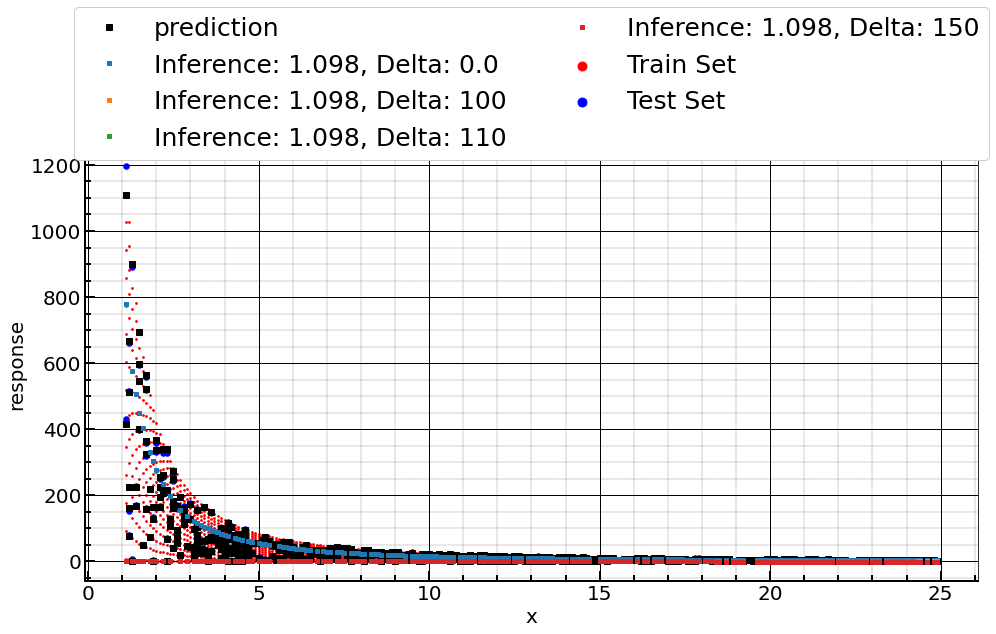

In [20]:
plot_inference_(model, 1.0989010989010988,
               [0.0, 100, 110, 150], 
               plotInference = True,
              logScale = False)


- When we are dealing with an asymptotic trend it is very difficult to see the differences between the extraolated curves.
- For this reason we are plotting the same curves but using a **log-log** scale.



Chosen mesh size: 1.0989010989010988
Chosen delta: [0.0, 100, 110, 150]
Available x2 values: [0.7092198581560283, 0.7633587786259541, 0.8264462809917354, 0.9009009009009008, 0.9900990099009901, 1.0989010989010988, 1.2345679012345678, 1.408450704225352, 1.6393442622950818, 1.9607843137254901, 2.4390243902439024, 3.2258064516129026, 4.761904761904762, 9.090909090909092, 100.0]
1.0989010989010988
New mesh [INFERENCE] 1.0989010989010988
New mesh [INFERENCE] 101.0989010989011
New mesh [INFERENCE] 111.0989010989011
New mesh [INFERENCE] 151.0989010989011


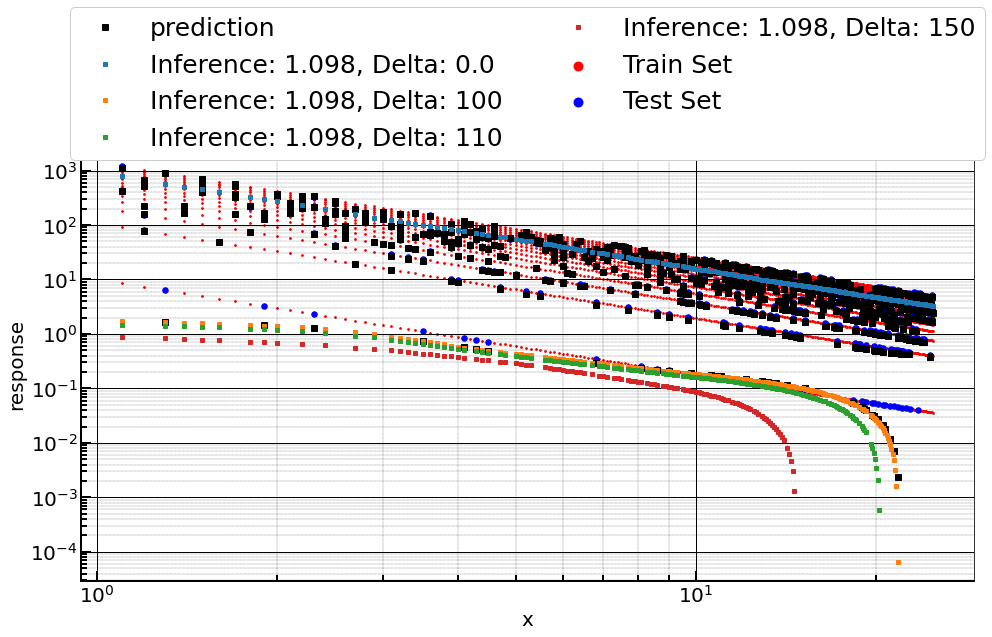

In [21]:
plotInference_(model, 1.0989010989010988,
               [0.0, 100, 110, 150], 
               plotInference = True,
              logScale = True)

# What if we do not have the whole curves?


- In the above example with feed the model with a dataset that shows a clear asymptotic trend.
- But, would the model learn the same even if we do not have the whole set of curves?
- Would the model be able to pick/understand there is an asymptotic behaviour even if only the initial set.



In [22]:
df

,x1,y,x2
11,1.1,0.008484,100.00000
12,1.2,0.007281,100.00000
13,1.3,0.006327,100.00000
14,1.4,0.005556,100.00000
15,1.5,0.004923,100.00000
...,...,...,...
3745,24.5,0.005220,0.70922
3746,24.6,0.005183,0.70922
3747,24.7,0.005146,0.70922
3748,24.8,0.005110,0.70922


In [23]:
df["x2"].unique()

array([100.        ,   9.09090909,   4.76190476,   3.22580645,
         2.43902439,   1.96078431,   1.63934426,   1.4084507 ,
         1.2345679 ,   1.0989011 ,   0.99009901,   0.9009009 ,
         0.82644628,   0.76335878,   0.70921986])

In [24]:
df_less = copy.deepcopy(df[df["x2"] < 4])

In [25]:
df_less

,x1,y,x2
761,1.1,0.262994,3.225806
762,1.2,0.225701,3.225806
763,1.3,0.196129,3.225806
764,1.4,0.172231,3.225806
765,1.5,0.152614,3.225806
...,...,...,...
3745,24.5,0.005220,0.709220
3746,24.6,0.005183,0.709220
3747,24.7,0.005146,0.709220
3748,24.8,0.005110,0.709220


In [26]:
df_less["x2"].unique()

array([3.22580645, 2.43902439, 1.96078431, 1.63934426, 1.4084507 ,
       1.2345679 , 1.0989011 , 0.99009901, 0.9009009 , 0.82644628,
       0.76335878, 0.70921986])

In [27]:
X = df_less.drop(columns = ["y"])
y = df_less["y"]*1000

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .2,
                                                    shuffle = True, 
                                                    random_state = 7)

early_stopping = callbacks.EarlyStopping(
    # Minimium amount of change to count as an improvement
    min_delta = 0.1, 
    # How many epochs to wait before stopping
    patience = 50, 
    restore_best_weights=True,
)

In [29]:
model = tf.keras.models.Sequential()
NoNeuronsPerLayer = 450
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu', input_dim = 2))
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu'))
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu'))
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu'))
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu'))
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'linear'))


model.compile(optimizer='adam', loss="MAE")
history = model.fit(X_train.values, y_train.values, 
                     epochs = 300, 
                     validation_data=(X_test, y_test), 
                     callbacks = [early_stopping])

prediction = model.predict(X_test)


Epoch 1/300
72/72 [==============================] - 1s 7ms/step - loss: 36.3810 - val_loss: 30.6429
Epoch 2/300
72/72 [==============================] - 0s 5ms/step - loss: 17.0699 - val_loss: 4.7325
Epoch 3/300
72/72 [==============================] - 0s 5ms/step - loss: 6.8640 - val_loss: 4.1804
Epoch 4/300
72/72 [==============================] - 0s 5ms/step - loss: 3.5504 - val_loss: 11.0609
Epoch 5/300
72/72 [==============================] - 0s 6ms/step - loss: 3.9304 - val_loss: 2.7101
Epoch 6/300
72/72 [==============================] - 0s 6ms/step - loss: 2.9881 - val_loss: 4.8387
Epoch 7/300
72/72 [==============================] - 0s 5ms/step - loss: 3.8078 - val_loss: 3.2364
Epoch 8/300
72/72 [==============================] - 0s 5ms/step - loss: 3.5058 - val_loss: 3.7625
Epoch 9/300
72/72 [==============================] - 0s 5ms/step - loss: 5.3852 - val_loss: 2.8825
Epoch 10/300
72/72 [==============================] - 0s 5ms/step - loss: 4.8795 - val_loss: 5.6171
Epoch

Epoch 83/300
72/72 [==============================] - 0s 5ms/step - loss: 1.1279 - val_loss: 0.9504
Epoch 84/300
72/72 [==============================] - 0s 6ms/step - loss: 1.6227 - val_loss: 2.0789
Epoch 85/300
72/72 [==============================] - 0s 5ms/step - loss: 2.0401 - val_loss: 1.0244
Epoch 86/300
72/72 [==============================] - 0s 5ms/step - loss: 1.2609 - val_loss: 1.4048
Epoch 87/300
72/72 [==============================] - 0s 5ms/step - loss: 1.1656 - val_loss: 1.9832
Epoch 88/300
72/72 [==============================] - 0s 5ms/step - loss: 2.1424 - val_loss: 0.9533
Epoch 89/300
72/72 [==============================] - 0s 5ms/step - loss: 1.0961 - val_loss: 1.0863
Epoch 90/300
72/72 [==============================] - 0s 5ms/step - loss: 1.2676 - val_loss: 1.0258
Epoch 91/300
72/72 [==============================] - 0s 5ms/step - loss: 1.3058 - val_loss: 1.1293
Epoch 92/300
72/72 [==============================] - 0s 5ms/step - loss: 1.6389 - val_loss: 1.6316


range(0, 128)


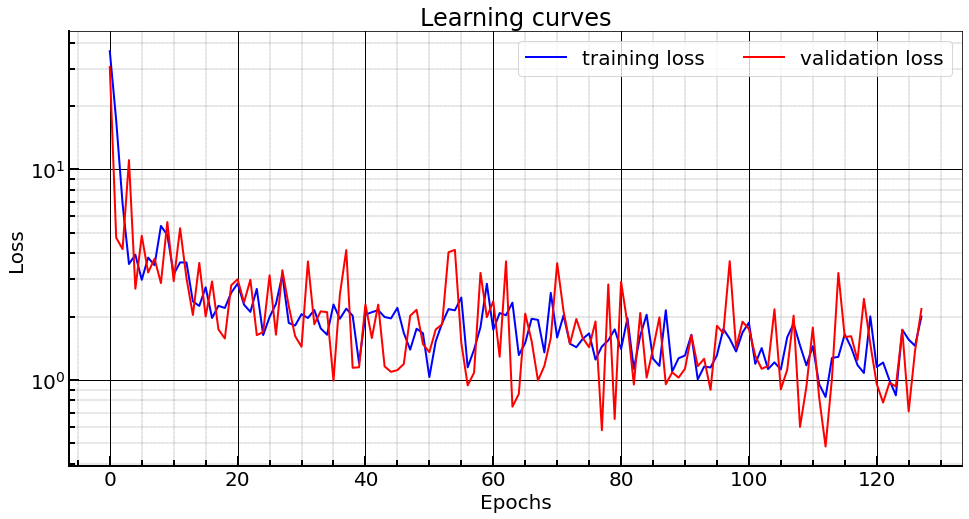

In [30]:
fig = plt.figure() 
plt.title("Learning curves")
ax = fig.add_subplot(111) 

dummy = range(len(history.history["loss"]))
print(dummy)

plt.plot(dummy, history.history["loss"], "-b", lw = 2, ms = 8, label = "training loss")
plt.plot(dummy, history.history["val_loss"], "-r", lw = 2, ms = 8, label = "validation loss")

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")

plt.yscale('log')
plt.legend(loc = 'upper right', ncol = 2);

In [31]:
preds = model.predict(X_test)

r2_s = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

print("MidModel [MSE]_test20%: ", mse)
print("MidModel [RMSE]_test20%: ", rmse)
print("MidModel [MAE]_test20%: ", mae)
print("MidModel [R2]_test20%: ", r2_s)

MidModel [MSE]_test20%:  3.076945548962386
MidModel [RMSE]_test20%:  1.754122444119106
MidModel [MAE]_test20%:  0.5769492726605668
MidModel [R2]_test20%:  0.9997301462803427


Chosen mesh size: 1.0989010989010988
Chosen delta: [0.0, 100, 110, 150]
Available x2 values: [0.7092198581560283, 0.7633587786259541, 0.8264462809917354, 0.9009009009009008, 0.9900990099009901, 1.0989010989010988, 1.2345679012345678, 1.408450704225352, 1.6393442622950818, 1.9607843137254901, 2.4390243902439024, 3.2258064516129026]
1.0989010989010988
New mesh [INFERENCE] 1.0989010989010988
New mesh [INFERENCE] 101.0989010989011
New mesh [INFERENCE] 111.0989010989011
New mesh [INFERENCE] 151.0989010989011


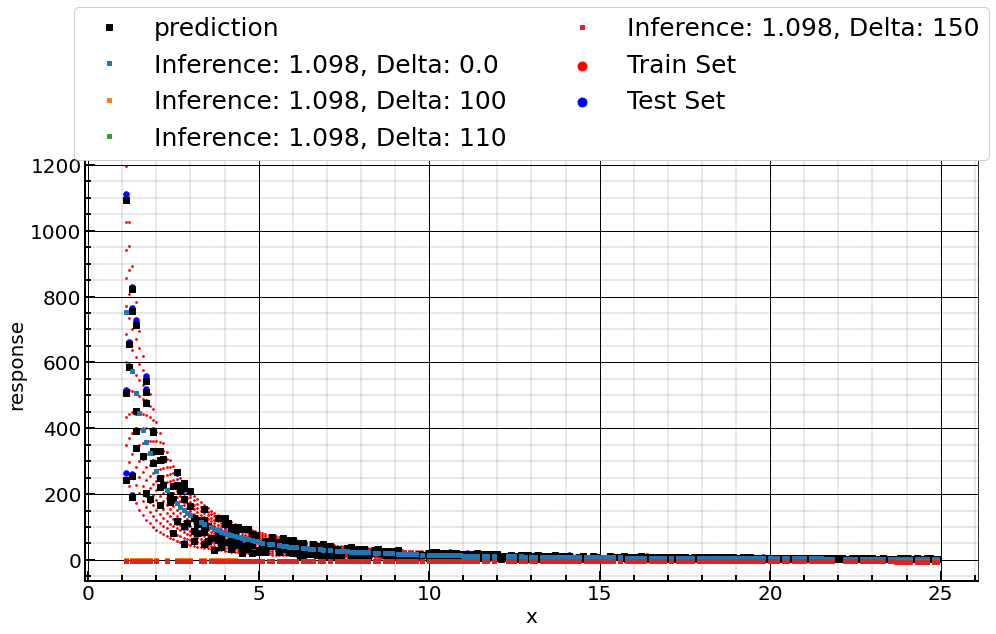

In [32]:
plotInference_(model, 1.0989010989010988,
               [0.0, 100, 110, 150], 
               plotInference = True,
              logScale = False)

Chosen mesh size: 1.0989010989010988
Chosen delta: [0.0, 5, 10, 20, 50, 100, 110, 150]
Available x2 values: [0.7092198581560283, 0.7633587786259541, 0.8264462809917354, 0.9009009009009008, 0.9900990099009901, 1.0989010989010988, 1.2345679012345678, 1.408450704225352, 1.6393442622950818, 1.9607843137254901, 2.4390243902439024, 3.2258064516129026]
1.0989010989010988
New mesh [INFERENCE] 1.0989010989010988
New mesh [INFERENCE] 6.0989010989010985
New mesh [INFERENCE] 11.098901098901099
New mesh [INFERENCE] 21.0989010989011
New mesh [INFERENCE] 51.0989010989011
New mesh [INFERENCE] 101.0989010989011
New mesh [INFERENCE] 111.0989010989011
New mesh [INFERENCE] 151.0989010989011


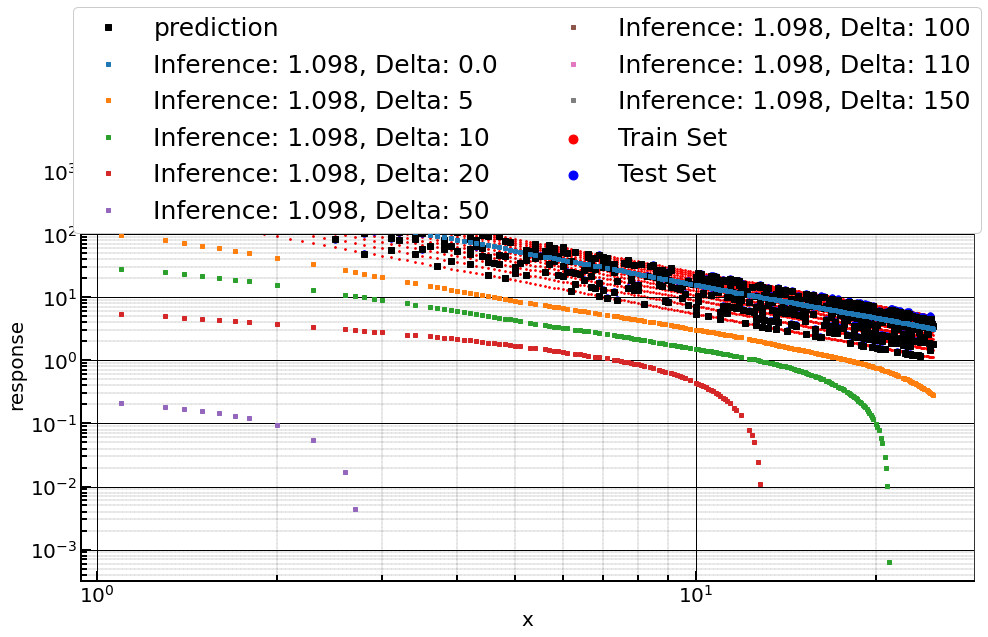

In [33]:
plotInference_(model, 1.0989010989010988,
               [0.0, 5, 10, 20, 50, 100, 110, 150], 
               plotInference = True,
              logScale = True)


- In this particular case we can see the trend is capture up to a certain degree.
- There is one **subtle difference** that needs to be mentioned here.
- The original points were sampled in a linear scale. When these are plotted in a log-log scale you can see points clustering in a way that do not cover well enough the left most side. This can be addressed by sampling in a log space directly. This is not done here but it would make the model more robust and would give it a fair chance to capture the trend to a higher degree.



# Feature engineering feeding the log scale only


- In this scenario we are going to log-transform the whole dataset.
- This should help the training to some degree.
- The point made about sampling in tihe log scale is still valid.
- **Note** that we are still using the truncated dataset because we'd like to see if log-scaling would help.
- `x2` is not log-scaled because there is no need.



In [34]:
df_less

,x1,y,x2
761,1.1,0.262994,3.225806
762,1.2,0.225701,3.225806
763,1.3,0.196129,3.225806
764,1.4,0.172231,3.225806
765,1.5,0.152614,3.225806
...,...,...,...
3745,24.5,0.005220,0.709220
3746,24.6,0.005183,0.709220
3747,24.7,0.005146,0.709220
3748,24.8,0.005110,0.709220


In [35]:
df_less["x1"] = np.log(df_less["x1"])
df_less["y"] = np.log(df_less["y"])

In [36]:
df_less

,x1,y,x2
761,0.095310,-1.335625,3.225806
762,0.182322,-1.488544,3.225806
763,0.262364,-1.628982,3.225806
764,0.336472,-1.758920,3.225806
765,0.405465,-1.879844,3.225806
...,...,...,...
3745,3.198673,-5.255251,0.709220
3746,3.202746,-5.262381,0.709220
3747,3.206803,-5.269481,0.709220
3748,3.210844,-5.276553,0.709220


In [37]:
X = df_less.drop(columns = ["y"])
y = df_less["y"]*1000

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .2,
                                                    shuffle = True, 
                                                    random_state = 7)

early_stopping = callbacks.EarlyStopping(
    # Minimium amount of change to count as an improvement
    min_delta = 0.1, 
    # How many epochs to wait before stopping
    patience = 50, 
    restore_best_weights=True,
)

In [39]:
model = tf.keras.models.Sequential()
NoNeuronsPerLayer = 450
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu', input_dim = 2))
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu'))
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu'))
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu'))
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu'))
model.add(tf.keras.layers.Dense(NoNeuronsPerLayer, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'linear'))


model.compile(optimizer='adam', loss="MAE")
history = model.fit(X_train.values, y_train.values, 
                     epochs = 300, 
                     validation_data=(X_test, y_test), 
                     callbacks = [early_stopping])

prediction = model.predict(X_test)


Epoch 1/300
72/72 [==============================] - 1s 6ms/step - loss: 1434.3225 - val_loss: 192.5904
Epoch 2/300
72/72 [==============================] - 0s 5ms/step - loss: 149.6961 - val_loss: 101.2404
Epoch 3/300
72/72 [==============================] - 0s 5ms/step - loss: 95.6905 - val_loss: 92.9177
Epoch 4/300
72/72 [==============================] - 0s 5ms/step - loss: 88.6491 - val_loss: 60.5187
Epoch 5/300
72/72 [==============================] - 0s 5ms/step - loss: 138.8789 - val_loss: 67.7429
Epoch 6/300
72/72 [==============================] - 0s 5ms/step - loss: 115.9158 - val_loss: 101.6814
Epoch 7/300
72/72 [==============================] - 0s 5ms/step - loss: 101.9244 - val_loss: 56.5152
Epoch 8/300
72/72 [==============================] - 0s 5ms/step - loss: 67.0676 - val_loss: 53.1376
Epoch 9/300
72/72 [==============================] - 0s 5ms/step - loss: 66.7096 - val_loss: 72.3271
Epoch 10/300
72/72 [==============================] - 0s 5ms/step - loss: 116.5933

range(0, 108)


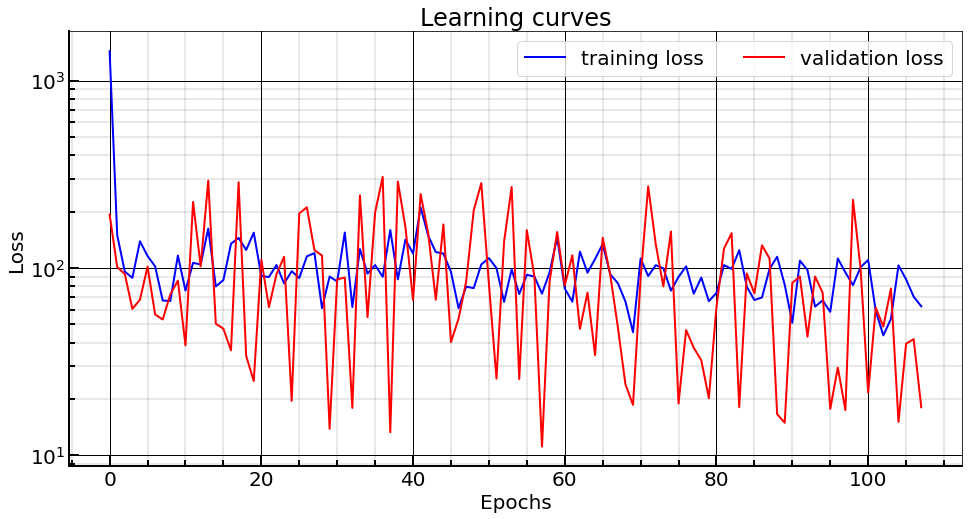

In [40]:
fig = plt.figure() 
plt.title("Learning curves")
ax = fig.add_subplot(111) 

dummy = range(len(history.history["loss"]))
print(dummy)

plt.plot(dummy, history.history["loss"], "-b", lw = 2, ms = 8, label = "training loss")
plt.plot(dummy, history.history["val_loss"], "-r", lw = 2, ms = 8, label = "validation loss")

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")

plt.yscale('log')
plt.legend(loc = 'upper right', ncol = 2);

In [41]:
preds = model.predict(X_test)

r2_s = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

print("MidModel [MSE]_test20%: ", mse)
print("MidModel [RMSE]_test20%: ", rmse)
print("MidModel [MAE]_test20%: ", mae)
print("MidModel [R2]_test20%: ", r2_s)

MidModel [MSE]_test20%:  243.17068831649112
MidModel [RMSE]_test20%:  15.593931137352477
MidModel [MAE]_test20%:  11.161591831885668
MidModel [R2]_test20%:  0.9998725742613069


Chosen mesh size: 1.0989010989010988
Chosen delta: [0.0, 100, 110, 150]
Available x2 values: [0.7092198581560283, 0.7633587786259541, 0.8264462809917354, 0.9009009009009008, 0.9900990099009901, 1.0989010989010988, 1.2345679012345678, 1.408450704225352, 1.6393442622950818, 1.9607843137254901, 2.4390243902439024, 3.2258064516129026]
1.0989010989010988
New mesh [INFERENCE] 1.0989010989010988
New mesh [INFERENCE] 101.0989010989011
New mesh [INFERENCE] 111.0989010989011
New mesh [INFERENCE] 151.0989010989011


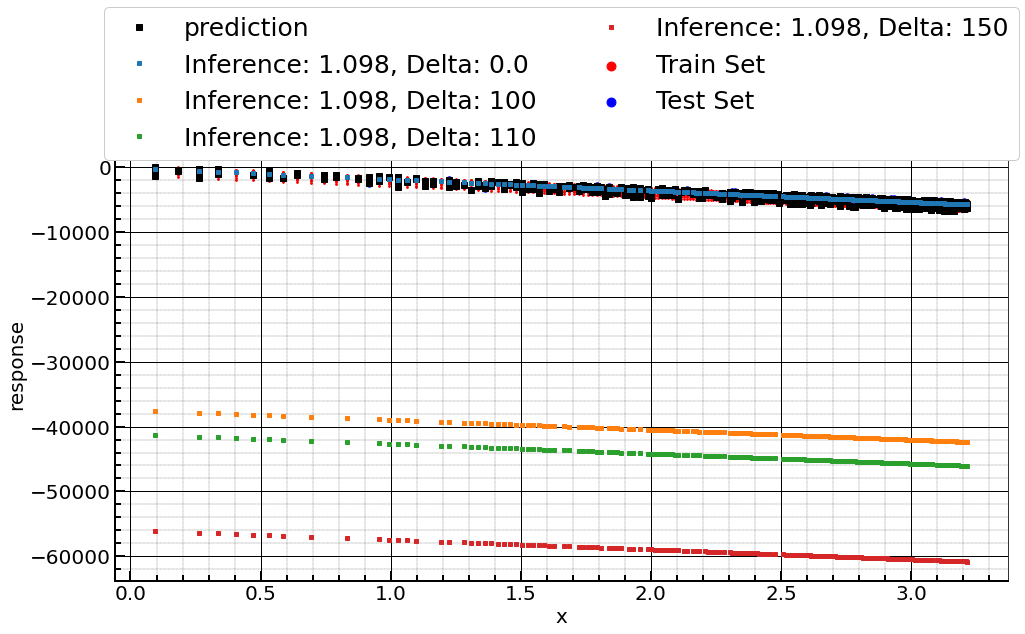

In [42]:
plotInference_(model, 1.0989010989010988,
               [0.0, 100, 110, 150], 
               plotInference = True,
              logScale = False)


- You can clearly see how the log-transform are helped in this case.
- Please bare in mind that if you want to see it in the real (linear) scale you have to use 10**values.



# Conclusions


- The problem is NOT a time series.
- We are dealing with extrapolation, NOT at the extrema, but behond them.
- Using the log-transformed of the data helped.



# References


- [Can regression trees predict continuously?](https://datascience.stackexchange.com/questions/9406/can-regression-trees-predict-continuously)
- [Order of convergence](https://www.grc.nasa.gov/www/wind/valid/tutorial/spatconv.html)
- [Log-log](https://measurebiology.org/wiki/Understanding_log_plots)

